<a href="https://colab.research.google.com/github/kundajelab/locusselect/blob/master/examples/regression%20on%20200%20bp%20genome%20bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
%load_ext autoreload
%reload_ext autoreload

%autoreload 2
%matplotlib inline
import tensorflow
from tensorflow.compat.v1.keras.backend import get_session
tensorflow.compat.v1.disable_v2_behavior()
import kerasAC 
from kerasAC.generators.tiledb_predict_generator import *
from scipy.special import softmax
from kerasAC.interpret.profile_shap import * 
from kerasAC.vis import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#load the model! 
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
from kerasAC.metrics import * 
from kerasAC.custom_losses import * 

custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "MultichannelMultinomialNLL":MultichannelMultinomialNLL}
get_custom_objects().update(custom_objects)


In [14]:
model=load_model("/srv/scratch/annashch/deeplearning/profile/k562_dnase/bpnet/seed.1234.cw.250.filters.500.naive.range.4.6.to.11.5/K562.profile.peaks.only.bpnet.withdups.1234seed.250counts.0.hdf5")

In [15]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
1st_conv (Conv1D)               (None, 1326, 500)    42500       sequence[0][0]                   
__________________________________________________________________________________________________
1stconv-crop_1th_dconv (Croppin (None, 1322, 500)    0           1st_conv[0][0]                   
__________________________________________________________________________________________________
2ndconv (Conv1D)                (None, 1322, 500)    750500      1st_conv[0][0]                   
____________________________________________________________________________________________

In [17]:

import shap
model_wrapper=(model.input, model.layers[-1].output)
#count_explainer=shap.DeepExplainer(model_wrapper,data=create_background,combine_mult_and_diffref=combine_mult_and_diffref)
prof_explainer = create_explainer(model)


HERE--tf
HERE--keras
here!


In [23]:
import pysam 
ref=pysam.FastaFile("/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")
flank=673
scramble_flank=75
out_flank=500
import tiledb 
db=tiledb.open("/srv/scratch/annashch/encode_dnase_tiledb/db/dnase/",'r')

In [31]:
#regions=[i.split('\t') for i in open("scrambles/myc.bed",'r').read().strip().split('\n')]
regions=[i.split('\t') for i in open("/srv/scratch/annashch/deeplearning/profile/k562_dnase/bpnet/interpret/regions_to_score.bed",'r').read().strip().split('\n')]

In [8]:
from kerasAC.util import * 
import random

(778215, 779215)


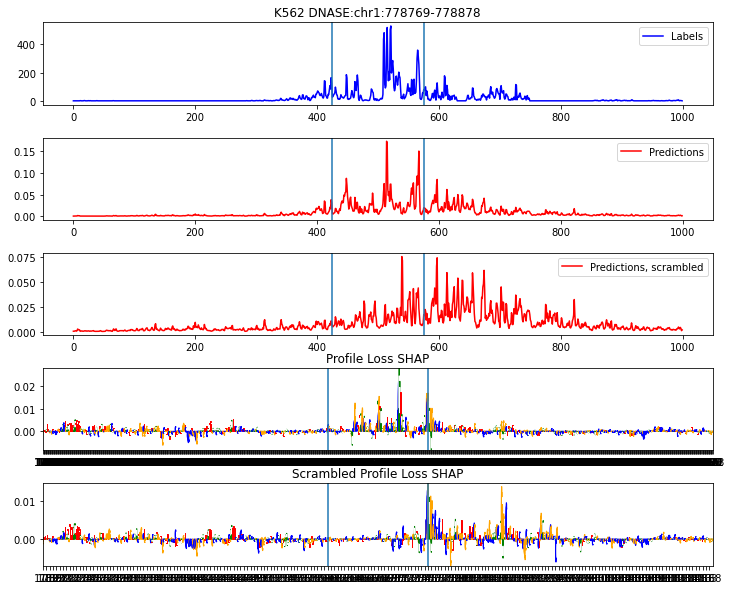

In [52]:
for region in regions[10:11]: 
    chrom=region[0] 
    start=int(region[1])
    end=int(region[2])
    center=start+int((start-end)/2)
    region_start=center-flank 
    region_end=center+flank 
    scramble_start=flank-scramble_flank 
    scramble_end=flank+scramble_flank 
    seq=ref.fetch(chrom,region_start,region_end)
    #scramble_start=173+700
    #scramble_end=173+800
    scrambled_seq=seq[0:scramble_start]+dinuc_shuffle(seq[scramble_start:scramble_end])+seq[scramble_end::]
    seq_onehot=one_hot_encode([seq])
    scrambled_onehot=one_hot_encode([scrambled_seq])
    X=[seq_onehot]
    X_scrambled=[scrambled_onehot]
    output_start_coord=center-out_flank 
    output_end_coord=center+out_flank 
    tdb_indices=coords_to_tdb_indices((chrom,output_start_coord,output_end_coord),db)
    print(tdb_indices)
    y_prof=db[tdb_indices[0]:tdb_indices[1]]['count_bigwig_unstranded_5p'][:,2]
    y_count=np.log(np.sum(y_prof))
    preds=model.predict(X)
    pred_prob=softmax(preds[0].squeeze())
    pred_counts=pred_prob*(preds[1].squeeze()) 

    preds_scrambled=model.predict(X_scrambled)
    pred_scrambled_prob=softmax(preds_scrambled[0].squeeze())
    pred_scrambled_counts=pred_scrambled_prob*(preds_scrambled[1].squeeze()) 

    
    profile_explanations=prof_explainer(seq_onehot,None,None)
    profile_scrambled_explanations=prof_explainer(scrambled_onehot,None,None)
    
    
    
    label_counts=y_prof
    label_prob=label_counts/sum(label_counts)
    plt.rcParams["figure.figsize"]=12,10
    fig, axes = plt.subplots(5, 1)
    axes[0].plot(label_counts,label='Labels',color='b')
    axes[1].plot(pred_counts,label='Predictions',color='r')
    axes[2].plot(pred_scrambled_counts,label='Predictions, scrambled',color='r')
    axes[0].set_title('K562 DNASE:'+chrom+":"+str(start)+"-"+str(end))
    axes[0].legend(loc=1)
    axes[1].legend(loc=1) 
    axes[2].legend(loc=1)
    axes[3]=plot_seq_importance(profile_explanations,X[0].squeeze(),xlim=(173+300,1173-300),axes=axes[3])
    axes[3].set_title("Profile Loss SHAP")
    axes[4]=plot_seq_importance(profile_scrambled_explanations,X_scrambled[0].squeeze(),xlim=(173,1173),axes=axes[4])
    axes[4].set_title("Scrambled Profile Loss SHAP")
    axes[0].axvline(x=425)
    axes[0].axvline(x=575)
    axes[1].axvline(x=425)
    axes[1].axvline(x=575)
    axes[2].axvline(x=425)
    axes[2].axvline(x=575)
    axes[3].axvline(x=173+425)
    axes[3].axvline(x=173+575)
    axes[4].axvline(x=173+425)
    axes[4].axvline(x=173+575)
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    